In [1]:
%%capture
%cd ..

In [2]:
import os
from pathlib import Path
from birds import config
from birds.utils.kaggle import download_dataset

In [3]:
if download_dataset(config.OWNER, config.DATASET, config.DATA_PATH):
    import os
    import tarfile

    with tarfile.open(Path(config.DATA_PATH) / "CUB_200_2011.tgz", "r:gz") as tar:
        tar.extractall(path=config.DATA_PATH)

    os.remove(Path(config.DATA_PATH) / "CUB_200_2011.tgz")
    os.remove(Path(config.DATA_PATH) / "segmentations.tgz")


['segmentations.tgz', 'CUB_200_2011.tgz']


In [4]:
from fastai.vision.all import *

In [5]:
path = Path(config.DATA_PATH) / "CUB_200_2011"

In [6]:
with open(path / "images.txt", "r") as file:
    lines = [line.strip().split()[1] for line in file.readlines()]
len(lines), lines[15]

(11788, '001.Black_footed_Albatross/Black_Footed_Albatross_0016_796067.jpg')

In [7]:
def get_birds_images(path):
    with open(path / "images.txt", "r") as file:
        lines = [path.resolve() / "images" / line.strip().split()[1] for line in file.readlines()]
    return lines

In [8]:
lines = get_birds_images(path)
len(lines), lines[15]

(11788,
 Path('/home/jcarnero/source/machine-learning/birds-classification/data/200-bird-species-with-11788-images/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0016_796067.jpg'))

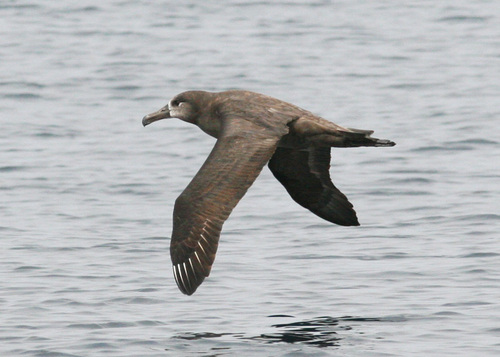

In [9]:
im = PILImage.create(lines[15])
im

In [10]:
with open(path / "train_test_split.txt", "r") as file:
    lines = [line.strip() for line in file.readlines()]
len(lines), lines[15]

(11788, '16 0')

In [11]:
def is_valid(i: str) -> bool:
    return i == '1'

In [12]:
lines[15], is_valid(lines[15].split()[1]), lines[4], is_valid(lines[4].split()[1])

('16 0', False, '5 1', True)

In [13]:
def BirdsSplitter(path):
    with open(path / "train_test_split.txt", "r") as file:
        valid_idx = [int(line.strip().split()[0]) - 1 for line in file.readlines() if line.strip().split()[1] == '1']
    return IndexSplitter(valid_idx)

In [14]:
splitter = BirdsSplitter(path)
split = splitter(get_birds_images(path))
split

((#5794) [0,2,5,9,11,12,13,15,16,18...], (#5994) [1,3,4,6,7,8,10,14,17,19...])

In [15]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.0, 1.0))
batch_tfms = [
    *aug_transforms(size=224, max_warp=0),
    Normalize.from_stats(*imagenet_stats),
]
bs = 64

In [16]:
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_birds_images,
    splitter=BirdsSplitter(path),
    get_y=RegexLabeller(pat=r"/([^/]+)_\d+_\d+\.jpg"),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

In [18]:
dls = birds.dataloaders(path)

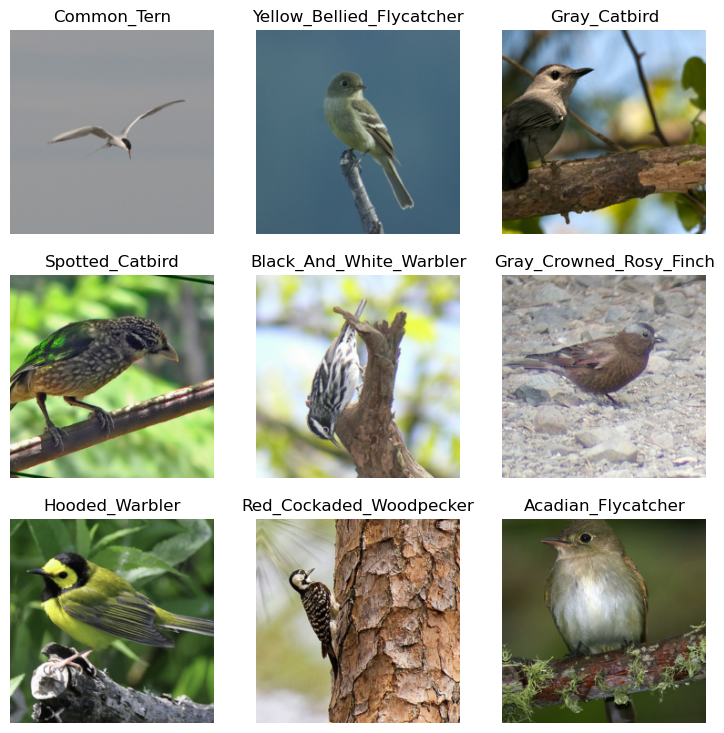

In [19]:
dls.show_batch()

In [20]:
dls.vocab

['Acadian_Flycatcher', 'American_Crow', 'American_Goldfinch', 'American_Pipit', 'American_Redstart', 'American_Three_Toed_Woodpecker', 'Anna_Hummingbird', 'Artic_Tern', 'Baird_Sparrow', 'Baltimore_Oriole', 'Bank_Swallow', 'Barn_Swallow', 'Bay_Breasted_Warbler', 'Belted_Kingfisher', 'Bewick_Wren', 'Black_And_White_Warbler', 'Black_Billed_Cuckoo', 'Black_Capped_Vireo', 'Black_Footed_Albatross', 'Black_Tern', 'Black_Throated_Blue_Warbler', 'Black_Throated_Sparrow', 'Blue_Grosbeak', 'Blue_Headed_Vireo', 'Blue_Jay', 'Blue_Winged_Warbler', 'Boat_Tailed_Grackle', 'Bobolink', 'Bohemian_Waxwing', 'Brandt_Cormorant', 'Brewer_Blackbird', 'Brewer_Sparrow', 'Bronzed_Cowbird', 'Brown_Creeper', 'Brown_Pelican', 'Brown_Thrasher', 'Cactus_Wren', 'California_Gull', 'Canada_Warbler', 'Cape_Glossy_Starling', 'Cape_May_Warbler', 'Cardinal', 'Carolina_Wren', 'Caspian_Tern', 'Cedar_Waxwing', 'Cerulean_Warbler', 'Chestnut_Sided_Warbler', 'Chipping_Sparrow', 'Chuck_Will_Widow', 'Clark_Nutcracker', 'Clay_Colore

In [21]:
len(dls.vocab)

200

In [22]:
# dls.vocab.o2i

In [23]:
learner = vision_learner(dls, "vit_tiny_patch16_224", metrics=[accuracy])

SuggestedLRs(valley=0.001737800776027143)

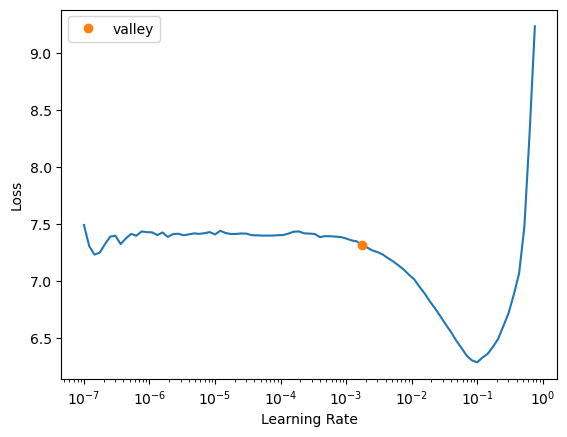

In [24]:
learner.lr_find()

In [26]:
learner.fine_tune(4, base_lr=0.001, freeze_epochs=4)

In [27]:
learner.export("models/vit_exported")
learner.save("vit_saved", with_opt=False)

Path('models/vit_saved.pth')

In [28]:
interp = ClassificationInterpretation.from_learner(learner)

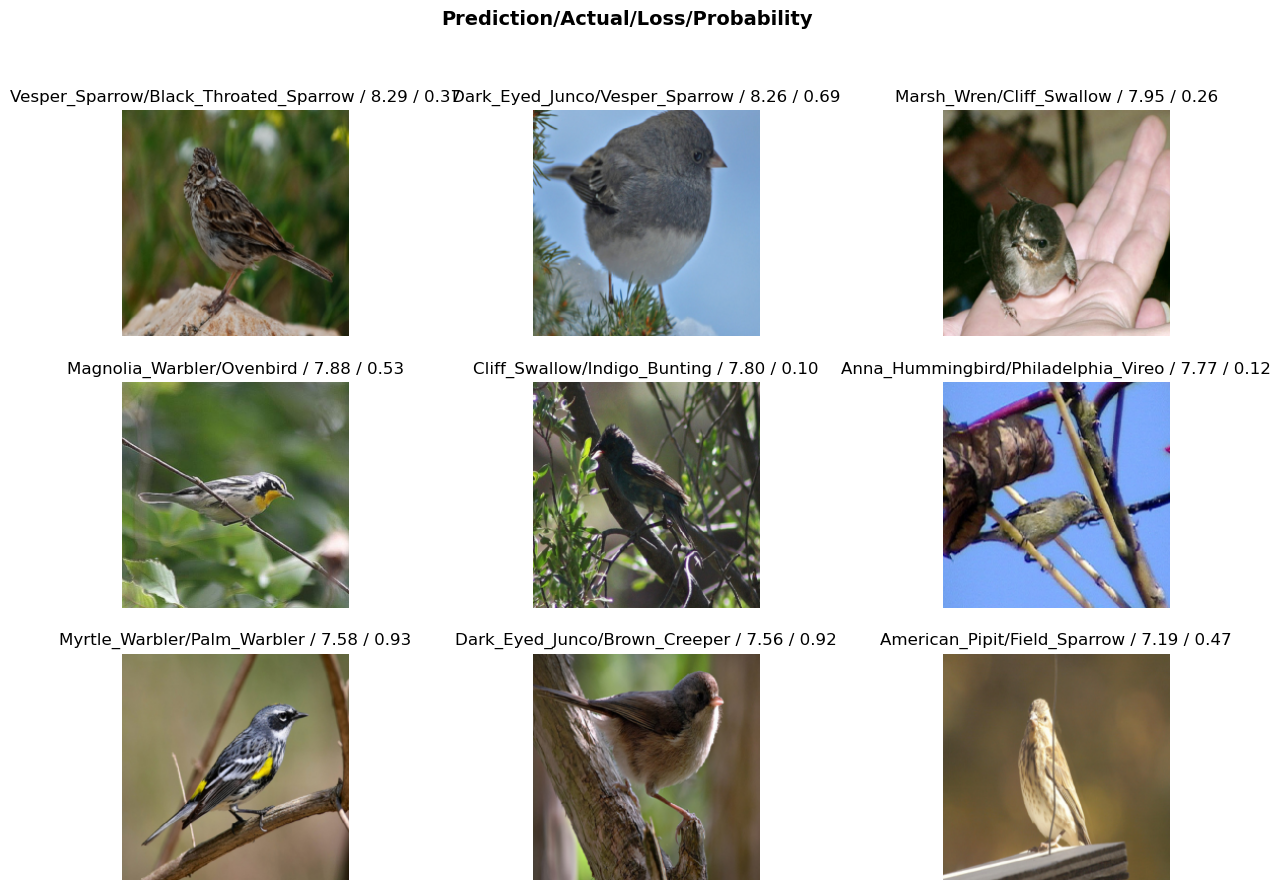

In [29]:
interp.plot_top_losses(9, figsize=(15,10))

In [30]:
# # interp.plot_confusion_matrix(figsize=(12,12), dpi=100)  # dpi adjust the resolution